**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [2]:
!pip3 install scikit-video

     |████████████████████████████████| 2.3MB 3.3MB/s 


In [3]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo.io
import cv2
import json
import random


from keras.models import Sequential,model_from_json
from keras.layers.core import Dense, Flatten
from keras.optimizers import sgd
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization

Using TensorFlow backend.


In [0]:
import keras
import tensorflow as tf

config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [5]:
print("GPU Available: ", tf.test.is_gpu_available(cuda_only=True))

GPU Available:  True


# MiniProject on Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [0]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [0]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]

            else:
                a = self.learned_act(s)

        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

```epsilon``` is the probability under which the agent picks a random action for the next step.
If we hit above this threshold the agent then acts via the policy previously learned. It allows our algorithm to learn and not only to reproduce the actions it already tried. It parametrizes the percentage of exploration we allow for our model.

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [0]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [0]:
# parameters
size = 13
T=200
temperature=0.3
epochs_train=30 # set small when debugging
epochs_test=15 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

* ```position``` is a grid with the same size as the board with -1 values everywhere except for the location of the rat at instant t

* ```board``` is a NxN grid with the remaining aliment values on the board. For each cell it has 0 if it hasn't any aliment in it initially or if the rat already ate it, otherwise it has the value of the reward for eating the aliment on the corresponding cell.

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [0]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        return np.random.randint(0, 4)

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [0]:
def test(agent,env,epochs,prefix='', with_actual=False):
    # Number of won games
    score = 0
        
    for e in range(epochs):
        agent.set_epsilon(0)
        ##### FILL IN HERE
        state = env.reset()
        # This assumes that the games will end
        game_over = False
    
        win = 0
        lose = 0
    
        while not game_over:
            # The agent performs an action
            action = agent.act(state)
    
            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state

            if with_actual:
                state, reward, game_over, actual_reward = env.act(action)
                if actual_reward > 0:
                    win = win + actual_reward # We only want to see the actual score without the "coming back" penalty
                if actual_reward < 0:
                    lose = lose -actual_reward
            else:
                state, reward, game_over = env.act(action)
                # Update the counters
                if reward > 0:
                    win = win + reward
                if reward < 0:
                    lose = lose - reward
        
        # Save as a mp4
        env.draw(prefix+str(e))

        # Update stats
        score = score + win-lose

        print("Win/lose count {}/{}. Average score ({})"
              .format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))

In [12]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

test(agent,env,epochs_test,prefix='random')
HTML(display_videos('random0.mp4'))

Win/lose count 10.0/17.0. Average score (-7.0)
Win/lose count 6.5/17.0. Average score (-8.75)
Win/lose count 13.0/15.0. Average score (-6.5)
Win/lose count 4.5/12.0. Average score (-6.75)
Win/lose count 11.5/15.0. Average score (-6.1)
Win/lose count 10.5/21.0. Average score (-6.833333333333333)
Win/lose count 12.0/13.0. Average score (-6.0)
Win/lose count 10.5/15.0. Average score (-5.8125)
Win/lose count 6.0/14.0. Average score (-6.055555555555555)
Win/lose count 8.0/18.0. Average score (-6.45)
Win/lose count 14.0/14.0. Average score (-5.863636363636363)
Win/lose count 6.0/9.0. Average score (-5.625)
Win/lose count 10.0/11.0. Average score (-5.269230769230769)
Win/lose count 10.0/17.0. Average score (-5.392857142857143)
Win/lose count 10.5/13.0. Average score (-5.2)
Final score: -5.2


***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




***
__Answer__: 

***Proof 1***

Given the following definition of $Q^{\pi}$:

\begin{equation*}
Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\geq 0}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> 
\end{equation*}

We thus have:

\begin{align*}
Q^\pi(s,a)&=E_{p^{\pi}}\left[r(s, a) + \gamma\sum_{t\geq 0}\gamma^{t}r(s_{t+1},a_{t+1})|s_{0}=s,a_{0}=a\right] \> \\
&= E_{(s',a')\sim p(.|s,a)} \left[ r(s, a) + \gamma E_{p^{\pi}}\left[\sum_{t\geq 0}\gamma^{t}r(s_{t+1},a_{t+1})|s_{0}=s,a_{0}=a \right]\right]
\end{align*}

Which gives us the first equation:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}




***Proof 2***

We have:
\begin{align*}
Q^*(s, a) &= \max_{\pi}Q^{\pi}(s, a)\\
&= \max_{\pi}E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')] \\
&= r(s,a)+\gamma \max_{\pi}E_{(s',a')\sim p(.|s,a)} \left[Q^{\pi}(s',a') \right]
\end{align*}

It should be pointed out that the $\max$ over the policies also implies a max over the action as the best policy is the one that maximizes the Q function and it determines the action that maximizes the value function.

\begin{align*}
Q^*(s, a) &= r(s,a)+\gamma E_{(s', a')\sim \pi^*(.|s,a)} \left[Q^*(s',a') \right]\\
&= r(s,a)+\gamma \max_{a'} E_{s'\sim \pi^*(.|s,a)} \left[Q^*(s',a') \right]\\
&= r(s,a)+\gamma  E_{s'\sim \pi^*(.|s,a)} \left[\max_{a'} Q^*(s',a') \right]\\
\end{align*}

Which gives us the second equation



***Proof 3***

The second equation gives us a dynamical way to find the Q action value function. Thus to reach convergence we learn the Q function and update it each time and record the loss as the difference between the update and the old value of Q. Thus a $L^2$ norm as described above can ensure us convergence as it tends to be zero when the updated Q value is equal to the old one.

***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [0]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
      if len(self.memory) < self.max_memory:
        self.memory.append(m)
      else:
        self.memory.pop(0) # if we have reached the max memory we pop the oldest element of our list
        self.memory.append(m)

    def random_access(self):
        index = np.random.randint(0, len(self.memory))
        return self.memory[index]

***
The pipeline we will use for training is given below:

In [0]:
def train(agent,env,epoch,prefix='', verbose=True):
    # Number of won games
    score = 0
    loss = 0

    hist = {}
    hist['loss'] = []
    hist['win-lose'] = []
    hist['score'] = []

    for e in range(1, epoch + 1):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state, action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose

        if verbose:
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
                  .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')

        hist['loss'].append(loss)
        hist['win-lose'].append(win - lose)
        hist['score'].append(score)
    return hist

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [0]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16,n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
       # We take the action that gives the best reward Q as a learned action 
        q_pred = self.model.predict(np.array([s]))[0]
        a = np.argmax(q_pred)
        return a

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        if len(self.memory.memory) < self.batch_size:
            return 0
        
        
        input_states = np.zeros((self.batch_size, 5,5,self.n_state)) # state with shape (5, 5, self.n_state)
        target_q = np.zeros((self.batch_size, 4))

        minibatch = np.array([self.memory.random_access() for i in range(self.batch_size)])
        input_states = np.array([item[0] for item in minibatch])
        next_states = np.array([item[1] for item in minibatch])
        pred_q = self.model.predict(input_states)
        next_state_pred_q = self.model.predict(next_states)
        
        for i in range(self.batch_size):
            ######## FILL IN
            s_, n_s_, a_, r_, game_over_ = minibatch[i]
            if game_over_:
                ######## FILL IN
                target_q[i, a_] = r_ # don't have to update Q the while in train() will end
            else:
                ######## FILL IN
                target_q[i] = pred_q[i]

                # We predict the next Q (with next state input) with the current 
                # policy and update it using Bellman Equation
                target_q[i, a_] = r_ + self.discount * np.max(next_state_pred_q[i])

            # input_states[i] = s_

        ######## FILL IN
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -3, 3)
        # input_states = input_states.reshape(self.batch_size, 5, 5, self.n_state)
        

        l = self.model.train_on_batch(input_states, target_q)


        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        # NN Model
        ####### FILL IN

        model = Sequential()
        model.add(Dense(64, input_shape=(5, 5, self.n_state)))
        model.add(Activation('relu'))
        model.add(Dense(32))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(4, activation='linear')) # Output layer with n_actions size
        # Here we use linear activation such that we don't have a Q-value between 0 and 1
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model


        

In [0]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_evolutions(hist, batch_size):


    ax1 = plt.subplot(1, 3, 1)
    ax1.plot(hist['loss'])
    plt.title('Loss evolution for batch size of {}'.format(batch_size))

    ax2 = plt.subplot(1, 3, 2)
    ax2.plot(hist['win-lose'])
    plt.title('Win-lose evolution for batch size of {}'.format(batch_size))

    ax3 = plt.subplot(1, 3, 3)
    ax3.plot(hist['score'])
    plt.title('Score evolution for batch size of {}'.format(batch_size))

    plt.show()

In [17]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(size, lr=1e-2, epsilon=0.1, memory_size=2000, batch_size = 64)
hist = train(agent, env, 30, prefix='fc_train')
HTML(display_videos('fc_train30.mp4'))











Epoch 001/030 | Loss 0.0060 | Win/lose count 0.5/7.0 (-6.5)
Epoch 002/030 | Loss 0.0092 | Win/lose count 4.0/4.0 (0.0)
Epoch 003/030 | Loss 0.0155 | Win/lose count 2.0/1.0 (1.0)
Epoch 004/030 | Loss 0.0130 | Win/lose count 1.0/2.0 (-1.0)
Epoch 005/030 | Loss 0.0076 | Win/lose count 2.0/5.0 (-3.0)
Epoch 006/030 | Loss 0.0038 | Win/lose count 3.0/3.0 (0.0)
Epoch 007/030 | Loss 0.0063 | Win/lose count 7.0/4.0 (3.0)
Epoch 008/030 | Loss 0.0027 | Win/lose count 2.0/2.0 (0.0)
Epoch 009/030 | Loss 0.0052 | Win/lose count 3.0/7.0 (-4.0)
Epoch 010/030 | Loss 0.0154 | Win/lose count 4.0/5.0 (-1.0)
Epoch 011/030 | Loss 0.0090 | Win/lose count 2.5/3.0 (-0.5)
Epoch 012/030 | Loss 0.0138 | Win/lose count 4.5/6.0 (-1.5)
Epoch 013/030 | Loss 0.0095 | Win/lose count 3.5/6.0 (-2.5)
Epoch 014/030 | Loss 0.0071 | Win/lose count 5.0/6.0 (-1.0)
Epoch 015/030 | Loss 0.0079 | Win/lose count 2.5/5.0 (-2.5)
Epoch 016/030 | Loss 0.0041 | Win/lose count 1.0/9.0 (-8.0)
Epoch 017/030 | Loss 0.0092 | Win/l

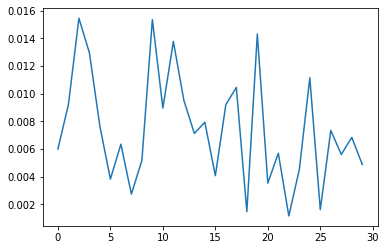

In [18]:
plt.plot(hist['loss'])

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [0]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        ###### FILL IN
        model = Sequential()
        model.add(Conv2D(32, 3, input_shape=(5, 5, self.n_state), padding='same'))
        # model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D())
        # model.add(Conv2D(32, 3, strides=2, padding='same'))
        model.add(Conv2D(64, 3, padding='same'))
        # model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D())
        # model.add(Conv2D(64, 3, strides=2, padding='same'))
        
        model.add(Flatten())
        model.add(Dense(4, activation='linear'))
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model

In [20]:
n_epochs = 100
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.01, epsilon=0.1, memory_size=2000, batch_size = 64)
train(agent,env, n_epochs, prefix='cnn_train')
HTML(display_videos('cnn_train{}.mp4'.format(str(n_epochs))))


Epoch 001/100 | Loss 0.0033 | Win/lose count 2.0/1.0 (1.0)
Epoch 002/100 | Loss 0.0043 | Win/lose count 1.5/3.0 (-1.5)
Epoch 003/100 | Loss 0.0059 | Win/lose count 2.5/2.0 (0.5)
Epoch 004/100 | Loss 0.0036 | Win/lose count 5.0/2.0 (3.0)
Epoch 005/100 | Loss 0.0055 | Win/lose count 2.0/2.0 (0.0)
Epoch 006/100 | Loss 0.0062 | Win/lose count 0.5/4.0 (-3.5)
Epoch 007/100 | Loss 0.0013 | Win/lose count 3.5/5.0 (-1.5)
Epoch 008/100 | Loss 0.0083 | Win/lose count 1.5/1.0 (0.5)
Epoch 009/100 | Loss 0.0079 | Win/lose count 2.0/7.0 (-5.0)
Epoch 010/100 | Loss 0.0048 | Win/lose count 3.5/3.0 (0.5)
Epoch 011/100 | Loss 0.0023 | Win/lose count 1.0/6.0 (-5.0)
Epoch 012/100 | Loss 0.0060 | Win/lose count 5.5/5.0 (0.5)
Epoch 013/100 | Loss 0.0054 | Win/lose count 4.0/5.0 (-1.0)
Epoch 014/100 | Loss 0.0014 | Win/lose count 2.0/6.0 (-4.0)
Epoch 015/100 | Loss 0.0045 | Win/lose count 2.5/1.0 (1.5)
Epoch 016/100 | Loss 0.0051 | Win/lose count 3.0/8.0 (-5.0)
Epoch 017/100 | Loss 0.0094 | Win/lose count 7.

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [21]:
epochs_test

15

In [22]:
env = Environment(grid_size=size, max_time=T,temperature=0.8)
agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')
print('Test of the CNN')
test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
test(agent_fc,env,epochs_test,prefix='fc_test')

Test of the CNN
Win/lose count 1.0/2.0. Average score (-1.0)
Win/lose count 5.0/0. Average score (2.0)
Win/lose count 2.0/2.0. Average score (1.3333333333333333)
Win/lose count 3.0/2.0. Average score (1.25)
Win/lose count 1.0/0. Average score (1.2)
Win/lose count 1.0/0. Average score (1.1666666666666667)
Win/lose count 1.0/0. Average score (1.1428571428571428)
Win/lose count 1.5/0. Average score (1.1875)
Win/lose count 3.5/0. Average score (1.4444444444444444)
Win/lose count 3.0/1.0. Average score (1.5)
Win/lose count 4.5/3.0. Average score (1.5)
Win/lose count 2.0/0. Average score (1.5416666666666667)
Win/lose count 4.5/0. Average score (1.7692307692307692)
Win/lose count 3.0/2.0. Average score (1.7142857142857142)
Win/lose count 5.0/0. Average score (1.9333333333333333)
Final score: 1.9333333333333333
Test of the FC
Win/lose count 2.0/0. Average score (2.0)
Win/lose count 0.5/0. Average score (1.25)
Win/lose count 1.5/1.0. Average score (1.0)
Win/lose count 0.5/1.0. Average score (0.

In [23]:
HTML(display_videos('cnn_test14.mp4'))

In [24]:
HTML(display_videos('fc_test14.mp4'))

Increasing the temperature leads to less poisons on the board and more healthy aliments for the rat.


Even if the CNN model has a better final test score than the Fully Connected one we can observe that our rat tends to come back to cells it already visited as the rewards are 0 there instead of exploring and possibly take a negative reward. To avoid this issue we will implement a "come-back penalty" when the rat returns on a cell it already visited.
This penalty is going to be :
* -0.1 if it is the first time the rat re-visit this cell
* malus * 1.2 until the malus is just below the poison malus if the rat re-visits a cell it already re-visited at least once.

To force exploring we are also going to need an epsilon-greedy strategy so that this epsilon is high at first and it then decreases as our model starts learning.

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [0]:
import math
def train_explore(agent,env,epoch,prefix='', verbose=True, dr=0.999):
        # Number of won games
    score = 0
    loss = 0

    hist = {}
    hist['loss'] = []
    hist['win-lose'] = []
    hist['score'] = []

    
    epsilon_start = agent.epsilon
    epsilon_end = 0.05 
    epsilon_drop = 200 # amount of decrease of eps each increment of t
    agent.set_epsilon(epsilon_start)
    print('Training model starting with epsilon=', agent.epsilon)
    steps_done = 0
    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        agent.set_epsilon((-epsilon_start/epoch)*e + epsilon_start)
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            agent.set_epsilon(agent.epsilon*dr) # we decrease epsilon each turn we play
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over, actual_reward = env.act(action, train=True)

            # Update the counters
            if actual_reward > 0:
                win = win + actual_reward # We only want to see the actual score without the "coming back" penalty
            if actual_reward < 0:
                lose = lose -actual_reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state, action, reward, game_over)
            steps_done += 1
        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose

        if verbose:
            print("Epoch {:03d}/{:03d} | Loss {:.4f} | Actual Win/lose count {}/{} ({})"
                  .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')

        hist['loss'].append(loss)
        hist['win-lose'].append(win - lose)
        hist['score'].append(score)

    print(agent.epsilon)
    return hist
        
class EnvironmentExploring(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))
        self.malus_position = np.zeros((grid_size, grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action, train=False):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = 0

        if train:
            reward = -self.malus_position[self.x, self.y]
 
        if self.malus_position[self.x, self.y] == 0:
            self.malus_position[self.x, self.y] = 0.1 # we put a 0.1 of malus on this case if we had not explored it
        else:
            # We multiply by 1.2 if already have explore the case to avoid loops
            # but we let the explored cases give less penalty than the poisons
            self.malus_position[self.x, self.y] *= 1.2 if self.malus_position[self.x, self.y] < 1/1.2 else 1


        reward = reward + self.board[self.x, self.y]
        actual_reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                        self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]
        
        return state, reward, game_over, actual_reward

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus
        self.malus_position = np.zeros((self.grid_size,self.grid_size))
        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                               self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state
    

In [26]:
# Training
n_train = 101
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=.1, epsilon=0.1, memory_size=2000, batch_size = 64, n_state=3)
hist = train_explore(agent, env, n_train, prefix='cnn_train_explore')
vid_name = 'cnn_train_explore{}.mp4'.format(n_train - 1)
HTML(display_videos(vid_name))

Training model starting with epsilon= 0.1
Epoch 000/101 | Loss 0.0212 | Actual Win/lose count 12.0/8.0 (4.0)
Epoch 001/101 | Loss 0.0222 | Actual Win/lose count 12.0/13.0 (-1.0)
Epoch 002/101 | Loss 0.0185 | Actual Win/lose count 11.5/6.0 (5.5)
Epoch 003/101 | Loss 0.0151 | Actual Win/lose count 11.0/5.0 (6.0)
Epoch 004/101 | Loss 0.0160 | Actual Win/lose count 14.0/6.0 (8.0)
Epoch 005/101 | Loss 0.0294 | Actual Win/lose count 16.5/5.0 (11.5)
Epoch 006/101 | Loss 0.0172 | Actual Win/lose count 21.5/5.0 (16.5)
Epoch 007/101 | Loss 0.0159 | Actual Win/lose count 9.0/4.0 (5.0)
Epoch 008/101 | Loss 0.0121 | Actual Win/lose count 11.5/1.0 (10.5)
Epoch 009/101 | Loss 0.0199 | Actual Win/lose count 11.5/6.0 (5.5)
Epoch 010/101 | Loss 0.0241 | Actual Win/lose count 26.5/3.0 (23.5)
Epoch 011/101 | Loss 0.0401 | Actual Win/lose count 20.0/3.0 (17.0)
Epoch 012/101 | Loss 0.0971 | Actual Win/lose count 17.5/6.0 (11.5)
Epoch 013/101 | Loss 0.0197 | Actual Win/lose count 20.0/3.0 (17.0)
Epoch 014/10

In [27]:
# Evaluation
test(agent,env,epochs_test,prefix='cnn_test_explore', with_actual=True)
HTML(display_videos('cnn_test_explore10.mp4'))

Win/lose count 25.5/4.0. Average score (21.5)
Win/lose count 28.5/4.0. Average score (23.0)
Win/lose count 21.0/7.0. Average score (20.0)
Win/lose count 32.5/8.0. Average score (21.125)
Win/lose count 21.0/9.0. Average score (19.3)
Win/lose count 19.0/5.0. Average score (18.416666666666668)
Win/lose count 27.0/6.0. Average score (18.785714285714285)
Win/lose count 24.0/4.0. Average score (18.9375)
Win/lose count 25.5/4.0. Average score (19.22222222222222)
Win/lose count 23.0/8.0. Average score (18.8)
Win/lose count 24.5/8.0. Average score (18.59090909090909)
Win/lose count 25.5/5.0. Average score (18.75)
Win/lose count 27.0/3.0. Average score (19.153846153846153)
Win/lose count 20.0/8.0. Average score (18.642857142857142)
Win/lose count 24.5/6.0. Average score (18.633333333333333)
Final score: 18.633333333333333


***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

***